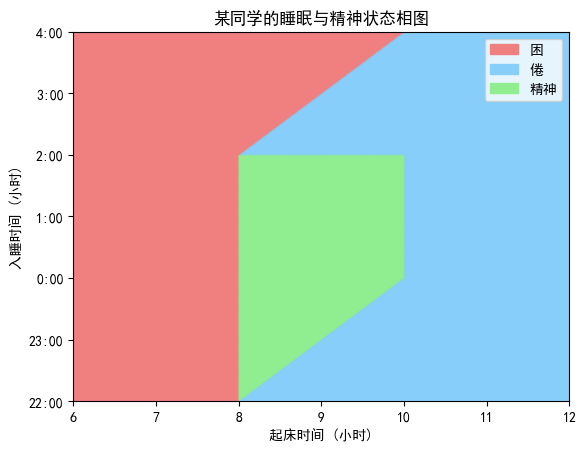

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, colors, image

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置横纵坐标范围
wake_times = np.linspace(6, 12, 300)  # 早上起床时间 6:00 - 12:00，增加采样点使边缘更平滑
sleep_times = np.linspace(22, 28, 300)  # 晚上入睡时间 22:00 - 28:00（24小时制，28表示次日4:00），增加采样点使边缘更平滑
wake_grid, sleep_grid = np.meshgrid(wake_times, sleep_times)

# 计算睡眠时长
sleep_duration = (24 + wake_grid - sleep_grid) % 24

# 创建状态区域
status = np.full(sleep_duration.shape, '精神')

# 标记"困"的区域
status[sleep_duration < 6] = '困'
status[(sleep_grid > 26) & (status == '精神')] = '倦'  # 晚于2:00入睡记为倦
status[(wake_grid < 8) & (status == '精神')] = '困'  # 早于8:00起记为困

# 标记"倦"的区域
status[sleep_duration > 10] = '倦'
status[(wake_grid > 10) & (status == '精神')] = '倦'  # 晚于10:00起记为倦

# 绘图
fig, ax = plt.subplots()
cmap = {'困': 'lightcoral', '倦': 'lightskyblue', '精神': 'lightgreen'}
color_mapping = np.vectorize(cmap.get)(status)

# 将颜色转换为数值编码
unique_colors = list(cmap.values())
color_indices = np.zeros_like(status, dtype=int)
for idx, color in enumerate(unique_colors):
    color_indices[color_mapping == color] = idx

# 使用 pcolormesh 绘制
listed_cmap = colors.ListedColormap(unique_colors)
ax.pcolormesh(wake_grid, sleep_grid, color_indices, shading='gouraud', cmap=listed_cmap)  # 使用 gouraud 使边缘更光滑

# 设置坐标轴
ax.set_xlabel('起床时间 (小时)')
ax.set_ylabel('入睡时间 (小时)')
ax.set_xticks(np.arange(6, 13, 1))
ax.set_yticks(np.arange(22, 29, 1))
ax.set_yticklabels(['22:00', '23:00', '0:00', '1:00', '2:00', '3:00', '4:00'])
ax.set_title('某同学的睡眠与精神状态相图')

# 显示图例
from matplotlib.patches import Patch
legend_handles = [Patch(color=cmap['困'], label='困'),
                  Patch(color=cmap['倦'], label='倦'),
                  Patch(color=cmap['精神'], label='精神')]
ax.legend(handles=legend_handles, loc='upper right')

# 在精神区域内放置一张图片
# img = image.imread('1.jpg')  # 替换为你的图片路径
# image_extent = ('8:00', '10:00', '23:00', '24:00')  # 设置图片在坐标轴中的位置，(xmin, xmax, ymin, ymax)
# ax.imshow(img, extent=image_extent, aspect='auto', alpha=0.1)  # 添加图片到图中

# 保存图像
plt.savefig('spiritstatus.png', dpi=300, bbox_inches='tight')  # 保存为高分辨率图片

plt.show()


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio
import os

# 创建一些一维训练数据
np.random.seed(42)
x = np.array([[-2],[-1.5],[-1],[-0.5],[0.5],[1],[1.5],[2]])
y = np.array([[0],[1],[1],[0],[0],[1],[1],[0]])

# 定义一个简单的多层感知机模型，并加入权重初始化
class SimpleNN(nn.Module):
    def __init__(self, init_std=0.01):  # 添加初始化方差参数
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, 1)
        # 自定义权重初始化
        self._initialize_weights(init_std)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def _initialize_weights(self, init_std):
        # 对每一层的权重进行初始化，使用正态分布初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # 使用正态分布初始化权重，标准差由 init_std 参数控制
                nn.init.normal_(m.weight, mean=0, std=init_std)
                nn.init.normal_(m.bias, mean=0, std=init_std)

# 初始化模型、损失函数和优化器
model = SimpleNN(init_std=1/(1000)**0.5)  # 你可以调整初始化标准差（例如 0.05）
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 转换数据为 PyTorch 张量
x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)
x = np.linspace(-2, 2, 100)
xx = torch.tensor(x, dtype=torch.float32).view(-1, 1)
# 用于保存每个 epoch 的图像帧
images = []

# 训练过程
epochs = 30000
for epoch in range(epochs):
    model.train()
    
    # 前向传播
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 每隔一定次数保存一张权重和偏置的散点图
    if epoch % 500 == 0:
        plt.figure(figsize=(12, 6))
        
        # 获取第一层的权重和偏置
        fc1_weight = model.fc1.weight.detach().numpy().flatten()  # 转为一维
        fc1_bias = model.fc1.bias.detach().numpy()  # 偏置直接获取
        fc2_weight = model.fc2.weight.detach().numpy().flatten()
        # 计算 -bias / weight
        x_values = -fc1_bias / fc1_weight
        y_values = fc1_weight*fc2_weight
        
        # 绘制拟合情况
        plt.subplot(1, 2, 1)
        plt.scatter(x_train, y_train, label='Data Points', color='blue')
        plt.plot(x, model(xx).detach().numpy(), label='NN Fit', color='red')
        plt.legend()
        plt.title(f'Epoch {epoch} - std = 0.032 Fit')
        plt.xlabel('x')
        plt.ylabel('y')
        
        plt.subplot(1, 2, 2)
        # 绘制第一层参数的散点图
        plt.scatter(x_values, y_values, color='blue', label='Weight vs -Bias/Weight', alpha=0.7)
        plt.xlim((-2.5,2.5))
        plt.ylim((-0.5,0.5))
        plt.xlabel('-Bias / Weight')
        plt.ylabel('Weight')
        plt.title(f'Epoch {epoch} - First Layer Parameters')
        plt.legend()
        plt.tight_layout()
        
        # 保存图像
        plt.savefig(f'imagem/frame_{int(epoch/100)}.png')
        plt.close()
        
        # 读取保存的图片并加入帧列表
        images.append(imageio.imread(f'imagem/frame_{int(epoch/100)}.png'))

# 生成 GIF
imageio.mimsave('training_root_weight_m_0032.gif', images, fps=2)

MP4 文件已成功生成！


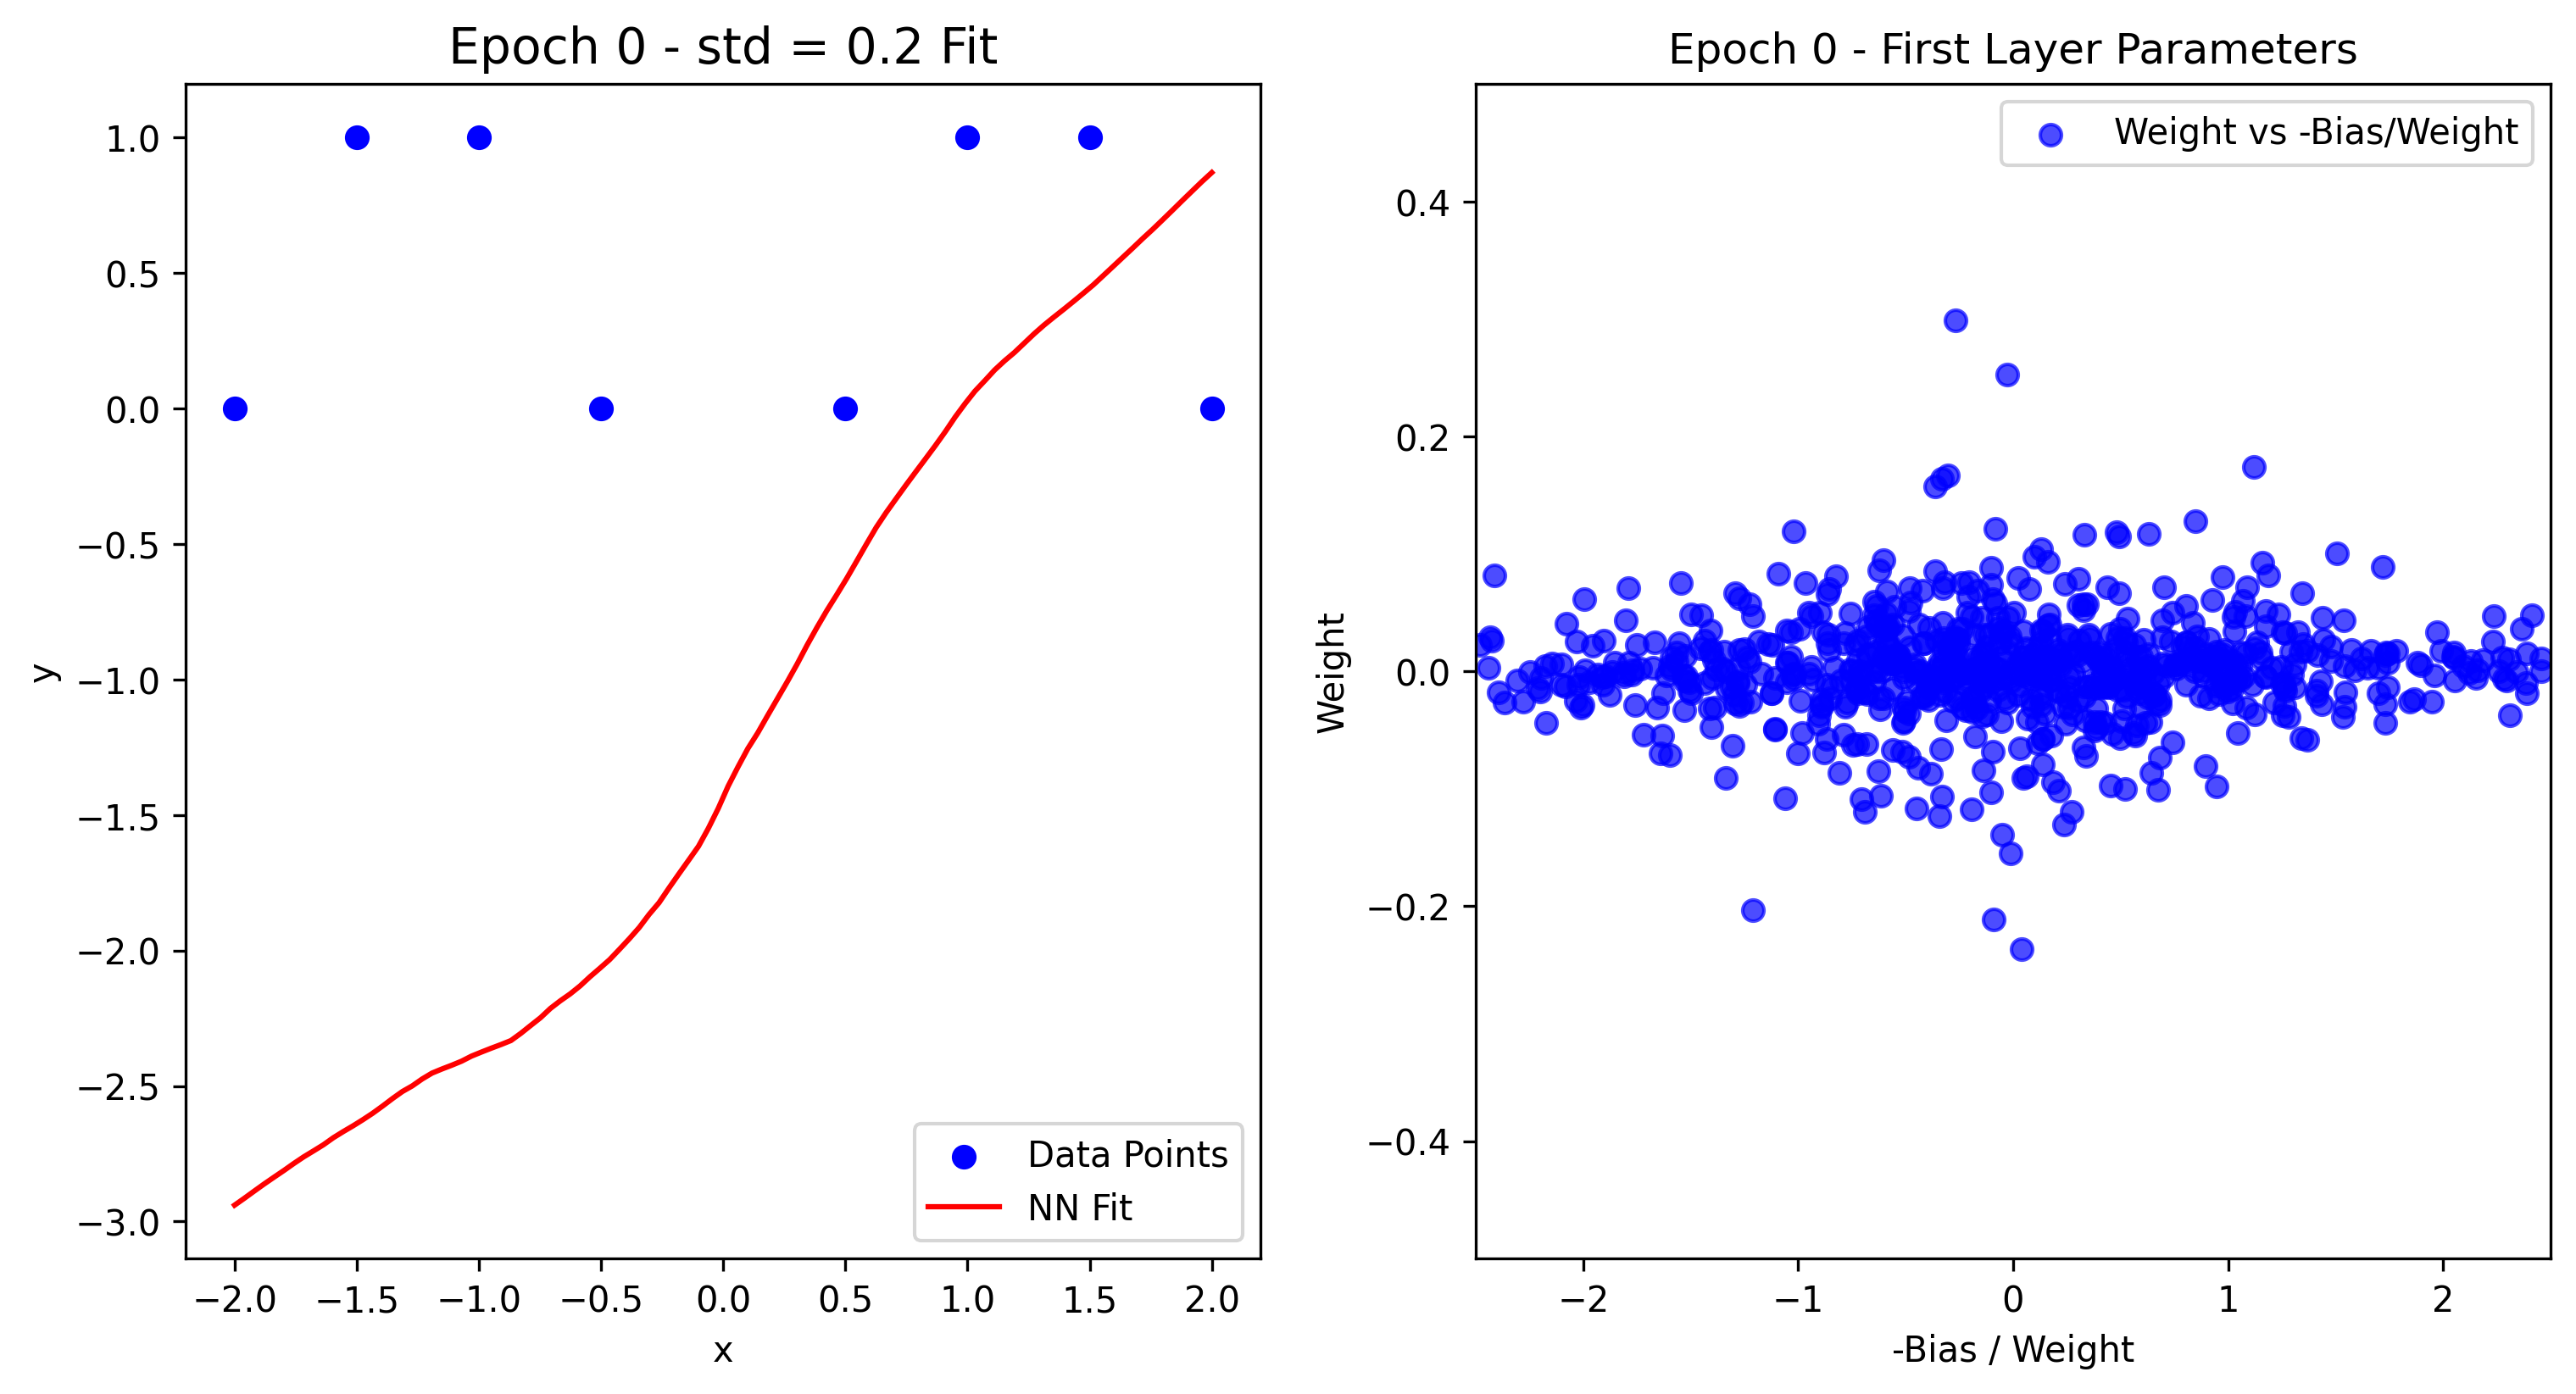

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = r'D:/ffmpeg-2024-10-31-git-87068b9600-full_build/bin/ffmpeg.exe'

# 创建一些一维训练数据
np.random.seed(42)
x = np.array([[-2], [-1.5], [-1], [-0.5], [0.5], [1], [1.5], [2]])
y = np.array([[0], [1], [1], [0], [0], [1], [1], [0]])

# 定义一个简单的多层感知机模型，并加入权重初始化
class SimpleNN(nn.Module):
    def __init__(self, init_std=0.01):  # 添加初始化方差参数
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 1000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1000, 1)
        # 自定义权重初始化
        self._initialize_weights(init_std)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def _initialize_weights(self, init_std):
        # 对每一层的权重进行初始化，使用正态分布初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # 使用正态分布初始化权重，标准差由 init_std 参数控制
                nn.init.normal_(m.weight, mean=0, std=init_std)
                nn.init.normal_(m.bias, mean=0, std=init_std)

# 初始化模型、损失函数和优化器
model = SimpleNN(init_std=0.2)  # 你可以调整初始化标准差（例如 0.05）
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 转换数据为 PyTorch 张量
x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)
x = np.linspace(-2, 2, 100)
xx = torch.tensor(x, dtype=torch.float32).view(-1, 1)

# 训练过程
epochs = 8000
save_interval = 200
frames_data = []

for epoch in range(epochs):
    model.train()
    
    # 前向传播
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 每隔一定次数保存绘图数据
    if epoch % save_interval == 0:
        # 获取第一层的权重和偏置
        fc1_weight = model.fc1.weight.detach().numpy().flatten()  # 转为一维
        fc1_bias = model.fc1.bias.detach().numpy()  # 偏置直接获取
        fc2_weight = model.fc2.weight.detach().numpy().flatten()
        
        # 计算 -bias / weight
        x_values = -fc1_bias / fc1_weight
        y_values = fc1_weight * fc2_weight

        # 存储数据以供绘制
        frames_data.append((epoch, x_values, y_values, model(xx).detach().numpy()))

# 用于绘制动画的函数
fig, axes = plt.subplots(1, 2, figsize=(12, 6),dpi=300)

def update_plot(frame_data):
    epoch, x_values, y_values, nn_fit = frame_data

    # 清除之前的内容
    for ax in axes:
        ax.clear()

    # 绘制拟合情况
    axes[0].scatter(x_train, y_train, label='Data Points', color='blue')
    axes[0].plot(x, nn_fit, label='NN Fit', color='red')
    axes[0].legend()
    axes[0].set_title(f'Epoch {epoch} - std = 0.2 Fit', fontsize=14)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    # 绘制第一层参数的散点图
    axes[1].scatter(x_values, y_values, color='blue', label='Weight vs -Bias/Weight', alpha=0.7)
    axes[1].set_xlim((-2.5, 2.5))
    axes[1].set_ylim((-0.5, 0.5))
    axes[1].set_xlabel('-Bias / Weight')
    axes[1].set_ylabel('Weight')
    axes[1].set_title(f'Epoch {epoch} - First Layer Parameters')
    axes[1].legend()

# 创建动画对象
ani = animation.FuncAnimation(fig, update_plot, frames=frames_data, repeat=False)

# 使用FFmpegWriter保存为高质量 MP4
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=5000)

# 保存动画为 MP4 文件
ani.save('training_02.mp4', writer=writer)

print("MP4 文件已成功生成！")


In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio
import os
import tqdm

# 创建一些一维训练数据
np.random.seed(42)
x = np.array([[-2], [-1.5], [-1], [-0.5], [0.5], [1], [1.5], [2]])
y = np.array([[0], [1], [1], [0], [0], [1], [1], [0]])

# 定义一个简单的多层感知机模型，并加入权重初始化
class SimpleNN(nn.Module):
    def __init__(self, layer=1000, init_std1=0.01, init_std2=0.05):  # 添加初始化方差参数
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, layer)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(layer, 1)
        # 自定义权重初始化
        self._initialize_weights(init_std1, init_std2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def _initialize_weights(self, init_std1, init_std2):
        # 对每一层的权重进行初始化，使用不同的正态分布初始化
        for name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                if name == 'fc1':
                    # 第一层使用标准差为 init_std1 的正态分布初始化权重和偏置
                    nn.init.normal_(m.weight, mean=0, std=init_std1)
                    nn.init.normal_(m.bias, mean=0, std=init_std1)
                elif name == 'fc2':
                    # 第二层使用标准差为 init_std2 的正态分布初始化权重和偏置
                    nn.init.normal_(m.weight, mean=0, std=init_std2)
                    nn.init.normal_(m.bias, mean=0, std=init_std2)

# 初始化模型、损失函数和优化器
layer = [1000, 5000, 10000, 20000, 40000]
ep = [10000, 50000, 100000,100000,200000]
x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)
rd = []

for i in range(len(layer)):
    m = layer[i]
    model = SimpleNN(layer=m, init_std1=m**(-0.25), init_std2=m**(-0.25))  # 分别设置每层的初始化标准差
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # 保存初始权重和偏置
    t0 = np.concatenate([
        model.fc1.weight.detach().numpy().flatten(),
        model.fc1.bias.detach().numpy().flatten(),
        model.fc2.weight.detach().numpy().flatten()
    ])
    
    epochs = ep[i]  # 减少训练次数以避免过长的训练时间
    for epoch in tqdm.tqdm(range(epochs), desc=f'Training model with layer size {m}'):  # 显示迭代进度
        model.train()
        
        # 前向传播
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 保存训练后的权重和偏置
    tt = np.concatenate([
        model.fc1.weight.detach().numpy().flatten(),
        model.fc1.bias.detach().numpy().flatten(),
        model.fc2.weight.detach().numpy().flatten()
    ])
    
    # 计算归一化距离
    rd.append(np.linalg.norm(tt - t0) / np.linalg.norm(t0))


Training model with layer size 40000: 100%|██████████| 200000/200000 [11:02<00:00, 301.87it/s]


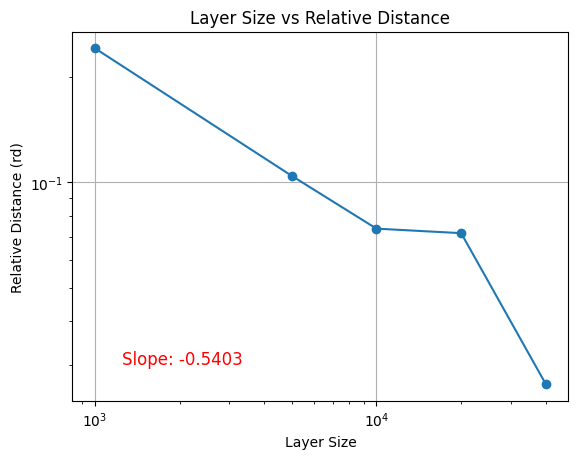

Slope: -0.540336739561476


In [47]:
from scipy.stats import linregress
# 绘制 layer 和 rd 的 loglog 图
plt.figure()
plt.loglog(layer, rd, marker='o')
plt.xlabel('Layer Size')
plt.ylabel('Relative Distance (rd)')
plt.title('Layer Size vs Relative Distance')
plt.grid(True)

# 计算斜率
log_layer = np.log(layer)
log_rd = np.log(rd)
slope, intercept, r_value, p_value, std_err = linregress(log_layer, log_rd)
plt.text(0.1, 0.1, f'Slope: {slope:.4f}', transform=plt.gca().transAxes, fontsize=12, color='red')
plt.savefig('layer_vs_rd_1.png')
plt.show()

print(f'Slope: {slope}')

In [48]:
rd2 = []

for i in range(len(layer)):
    m = layer[i]
    model = SimpleNN(layer=m, init_std1=m**(-0.5), init_std2=m**(-0.5))  # 分别设置每层的初始化标准差
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # 保存初始权重和偏置
    t0 = np.concatenate([
        model.fc1.weight.detach().numpy().flatten(),
        model.fc1.bias.detach().numpy().flatten(),
        model.fc2.weight.detach().numpy().flatten()
    ])
    
    epochs = ep[i]  # 减少训练次数以避免过长的训练时间
    for epoch in tqdm.tqdm(range(epochs), desc=f'Training model with layer size {m}'):  # 显示迭代进度
        model.train()
        
        # 前向传播
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 保存训练后的权重和偏置
    tt = np.concatenate([
        model.fc1.weight.detach().numpy().flatten(),
        model.fc1.bias.detach().numpy().flatten(),
        model.fc2.weight.detach().numpy().flatten()
    ])
    
    # 计算归一化距离
    rd2.append(np.linalg.norm(tt - t0) / np.linalg.norm(t0))

Training model with layer size 40000: 100%|██████████| 200000/200000 [11:06<00:00, 299.91it/s]


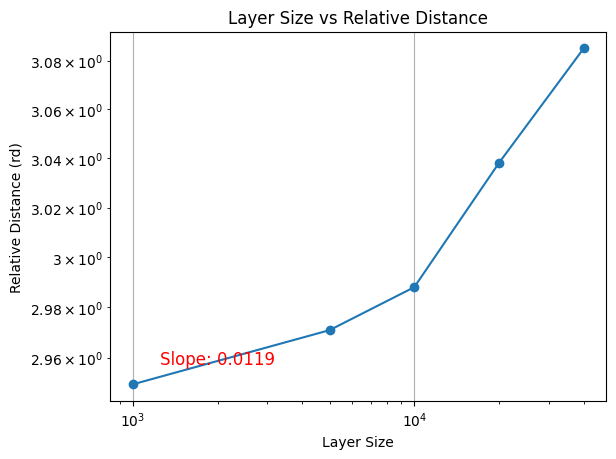

Slope: 0.011870480016115199


In [49]:
from scipy.stats import linregress
# 绘制 layer 和 rd 的 loglog 图
plt.figure()
plt.loglog(layer, rd2, marker='o')
plt.xlabel('Layer Size')
plt.ylabel('Relative Distance (rd)')
plt.title('Layer Size vs Relative Distance')
plt.grid(True)

# 计算斜率
log_layer = np.log(layer)
log_rd = np.log(rd2)
slope, intercept, r_value, p_value, std_err = linregress(log_layer, log_rd)
plt.text(0.1, 0.1, f'Slope: {slope:.4f}', transform=plt.gca().transAxes, fontsize=12, color='red')
plt.savefig('layer_vs_rd_2.png')
plt.show()

print(f'Slope: {slope}')

In [50]:
rd3 = []

for i in range(len(layer)):
    m = layer[i]
    model = SimpleNN(layer=m, init_std1=m**(-0.875), init_std2=m**(-0.875))  # 分别设置每层的初始化标准差
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # 保存初始权重和偏置
    t0 = np.concatenate([
        model.fc1.weight.detach().numpy().flatten(),
        model.fc1.bias.detach().numpy().flatten(),
        model.fc2.weight.detach().numpy().flatten()
    ])
    
    epochs = ep[i]  # 减少训练次数以避免过长的训练时间
    for epoch in tqdm.tqdm(range(epochs), desc=f'Training model with layer size {m}'):  # 显示迭代进度
        model.train()
        
        # 前向传播
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 保存训练后的权重和偏置
    tt = np.concatenate([
        model.fc1.weight.detach().numpy().flatten(),
        model.fc1.bias.detach().numpy().flatten(),
        model.fc2.weight.detach().numpy().flatten()
    ])
    
    # 计算归一化距离
    rd3.append(np.linalg.norm(tt - t0) / np.linalg.norm(t0))

Training model with layer size 40000: 100%|██████████| 200000/200000 [21:26<00:00, 155.51it/s] 


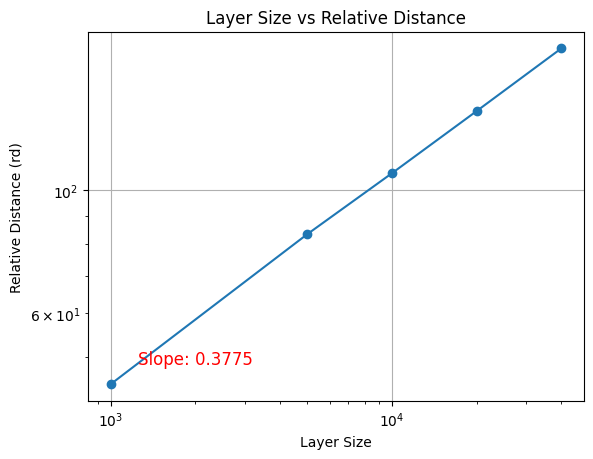

Slope: 0.3775119242406326


In [51]:
from scipy.stats import linregress
# 绘制 layer 和 rd 的 loglog 图
plt.figure()
plt.loglog(layer, rd3, marker='o')
plt.xlabel('Layer Size')
plt.ylabel('Relative Distance (rd)')
plt.title('Layer Size vs Relative Distance')
plt.grid(True)

# 计算斜率
log_layer = np.log(layer)
log_rd = np.log(rd3)
slope, intercept, r_value, p_value, std_err = linregress(log_layer, log_rd)
plt.text(0.1, 0.1, f'Slope: {slope:.4f}', transform=plt.gca().transAxes, fontsize=12, color='red')
plt.savefig('layer_vs_rd_3.png')
plt.show()

print(f'Slope: {slope}')